<a href="https://colab.research.google.com/github/Mv0sKff/MyDeepLearning/blob/main/misc/halfcheetah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning with Stable Baselines 3

In this exercise, you'll train a walking behavior using stable baselines, a library made for deep reinforcement learning.

In [1]:
import os
os.environ["MUJOCO_GL"] = "egl"
os.environ["EGL_DEVICE_ID"] = "0"

In [2]:
!pip install gymnasium==0.28.1 gymnasium[mujoco] stable_baselines3[extra]==2.0.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 35.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 M

First, let's import the necessary parts of the libraries for this exercise.

In [31]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

**Important:** should this step yield any errors, check if this notebook runs in the correct conda environment. Without the imports working, none of the following steps will work!

Next, we need to create the environments for which we want to learn a walking behavior. The goal of this environment is to make the robot move to the right side (positive x direction). For more information about the HalfCheetah environment, visit https://gymnasium.farama.org/environments/mujoco/half_cheetah/.

In [150]:
env_id = "HalfCheetah-v4"
env_raw = gym.make(env_id, render_mode="rgb_array")
# A seperate environment is required for evaluation
eval_env_raw = gym.make(env_id, render_mode="rgb_array")

With Deep Reinforcement Learning, an agent tries to maximize the reward it gets for the actions he performs. Your task is now to write a function to calculate the reward for the agent.

The following are the most important values that you can use for calculating the reward.
- `action` is an array containing the actions for the agent. The documentation linked above explains what these values represent.
- Use `self.env.data.xpos` to get the positions of the robot's body parts. As calling the "inner" environment's `step` method advances the simulation using the generated action, it makes a difference if you obtain those positions before calling `step` or after. This is a two-dimensional environment. Therefore, `self.env.data.xpos[?][1]` (the y-coordinate) is of no interest for all body parts. The following information is taken from the definition of the environment: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/mujoco/assets/half_cheetah.xml. The body parts should usually appear in the same order in the array as defined in the XML file using `<body>` tags.
  * `self.env.data.xpos[1]`: torso
  * `self.env.data.xpos[2]`: back thigh
  * `self.env.data.xpos[3]`: back shin
  * `self.env.data.xpos[4]`: back foot
  * `self.env.data.xpos[5]`: front thigh
  * `self.env.data.xpos[6]`: front shin
  * `self.env.data.xpos[7]`: front foot
- `self.dt` contains the time elapsed during the simulation step.

In [151]:
if os.path.exists("reward.txt"):
    os.remove("reward.txt")

In [152]:
def writeRewardToFile(reward):
  with open("reward.txt", "a") as f:
    f.write(str(reward)+"\n")

In [153]:
class HalfCheetahRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        x_position_torso_before = self.env.data.xpos[1][0]

        # Run the simulation and apply the action
        observation, _, terminated, truncated, info = self.env.step(action)

        x_position_torso_after = self.env.data.xpos[1][0]

        # TODO: calculate the reward here
        dt = self.env.model.opt.timestep
        #forward_velocity = (x_position_torso_after - x_position_torso_before) / dt

        reward = x_position_torso_after - x_position_torso_before
        reward = max(0.0, reward)

        writeRewardToFile(reward)

        return observation, reward, terminated, truncated, info

# Wrap the existing environments
env = HalfCheetahRewardWrapper(env_raw)
eval_env = Monitor(HalfCheetahRewardWrapper(eval_env_raw))

Now, we need to create the model. It is initialized with a random policy.
For this exercise, we'll use the PPO (Proximal Policy Optimization) algorithm.

In [154]:
model = None
if os.path.exists("ppo_halfcheetah"):
  model = PPO.load("ppo_halfcheetah", env=env)
else:
  model = PPO("MlpPolicy", env, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


If you'd like to see how random policy performs, you can comment out the following block:

In [155]:
# mean_reward, std_deviation = evaluate_policy(model, eval_env, n_eval_episodes=100)
# print("mean reward:", mean_reward)
# print("standard deviation:", std_deviation)

Now, it's time for learning how to walk. You can adjust the number of timesteps to learn on based on the strength of your computer. More timesteps take longer but may improve the resulting behavior.

In [156]:
#model.learn(total_timesteps=200000)
model.learn(total_timesteps=100000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 12.1     |
| time/              |          |
|    fps             | 677      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 12.4        |
| time/                   |             |
|    fps                  | 541         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011330252 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.49       |
|    explained_variance   | -20.277975  |
|    learning_rate        | 0.

Again, you can comment out the following block to measure if an improvement was made to the model compared to its initial random state.

In [157]:
#mean_reward, std_deviation = evaluate_policy(model, eval_env, n_eval_episodes=100)
#print("mean reward:", mean_reward)
#print("standard deviation:", std_deviation)

You can export a GIF of your trained behavior using the following code.

In [158]:
import imageio
import numpy as np

filename = "halfcheetah.gif"

images = []
obs = model.env.reset()
img = model.env.render()
start_pos = model.env.envs[0].data.xpos[1][0]
for _ in range(200):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _, _ = model.env.step(action)
    img = model.env.render()

end_pos = model.env.envs[0].data.xpos[1][0]
print(f"Distance travelled: {end_pos - start_pos}m")

imageio.mimsave(filename, [np.array(img) for img in images], duration=50)

Distance travelled: 6.6972992982235m


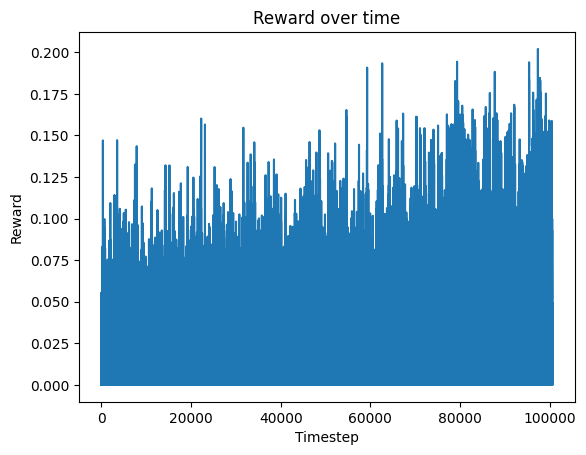

In [159]:
def plotReward():
  with open("reward.txt", "r") as f:
    rewards = f.readlines()
    rewards = [float(reward) for reward in rewards]

    import matplotlib.pyplot as plt
    plt.plot(rewards)
    plt.title("Reward over time")
    plt.xlabel("Timestep")
    plt.ylabel("Reward")
    plt.show()
plotReward()

In [160]:
model.save("ppo_halfcheetah")

Within the visualization, one side of a (black or white) square is $\frac{2}{3}$ meters long.

If you are interested in training robots in other environments, check out the already existing environments in Gymnasium: https://gymnasium.farama.org/environments/mujoco/.
You should be able to use another environment id and everything else in the notebook should mostly continue to work. Of course, you then need to find out yourself what the positions in `self.env.data.xpos` represent for your chosen environment.
Note: as of writing this (August 2023), there seem to be some problems with the Hopper and the Walker2D environment that prevent these environments from being used.

Now let's see how high the robot is able to jump. Once again, we need to define a reward function.
It might make sense to manually set `terminated` and `truncated` in this case.
Have a look at https://gymnasium.farama.org/api/env/#gymnasium.Env.step for an explanation of their meaning.

In [161]:
class HalfCheetahJumpRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        x_position_torso_before = self.env.unwrapped.data.xpos[1][0]

        obs, reward, terminated, truncated, info = self.env.step(action)

        x_position_torso_after = self.env.unwrapped.data.xpos[1][0]
        custom_reward = x_position_torso_after - x_position_torso_before

        return obs, custom_reward, terminated, truncated, info

# Wrap the existing environments
jump_env = HalfCheetahJumpRewardWrapper(env_raw)
jump_eval_env = Monitor(HalfCheetahJumpRewardWrapper(eval_env_raw))

Again, we need to create a new model.

In [162]:
jump_model = PPO("MlpPolicy", jump_env, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


To measure the performance of the random policy, comment out the following:

In [163]:
# mean_reward, std_deviation = evaluate_policy(jump_model, jump_eval_env, n_eval_episodes=100)
# print("mean reward:", mean_reward)
# print("standard deviation:", std_deviation)

Train the network:

In [164]:
jump_model.learn(total_timesteps=200) #200000

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -0.848   |
| time/              |          |
|    fps             | 725      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


As usual, you can run an evaluation to measure the new result:

In [165]:
# mean_reward, std_deviation = evaluate_policy(jump_model, jump_eval_env, n_eval_episodes=100)
# print("mean reward:", mean_reward)
# print("standard deviation:", std_deviation)

Of course, you can also export another GIF of your trained jumping behavior using the following code.

In [166]:
import imageio
import numpy as np

filename = "halfcheetah_jump.gif"

images = []
obs = jump_model.env.reset()
img = jump_model.env.render()
for _ in range(100):
    images.append(img)
    action, _ = jump_model.predict(obs)
    obs, _, _, _ = jump_model.env.step(action)
    img = jump_model.env.render()

imageio.mimsave(filename, [np.array(img) for img in images], duration=50)